In [163]:
import keras_tuner as kt
from tensorflow import keras
import numpy as np
import xarray as xr
import dask
import tensorflow as tf
from keras.layers.normalization.layer_normalization import *
from keras.layers.normalization.batch_normalization import *
from keras.layers import BatchNormalization
import tensorflow_probability as tfp
import clif
import clif.visualization as cviz
import matplotlib.pyplot as plt
import tensorflow.keras.backend as kb
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
import xarray
import haiku as hk
import jax 
from jax import numpy as jnp
from jax import value_and_grad
from sklearn import datasets
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import tensorflow_probability as tfp
from tensorflow.keras import layers
import sklearn

In [164]:
cd /Users/felixmeng/CME291/icme-xplore-bayes-spring22/src/data

/Users/felixmeng/CME291/icme-xplore-bayes-spring22/src/data


## Data Preprocessing

In [165]:
# open the data set and load it via chunks (dask) for efficient handling (optional)
season = 'DJF' # season
dataset = xr.open_mfdataset(f"../data/lat_lon_10yr_24x48_{season}.nc", chunks={'n': 1})
Y = dataset['SWCF']
X = dataset['lhs']
X_bnds = dataset['lhs_bnds']
# Load the observation or reference data
dataset_obs = xr.open_mfdataset(f"../data/lat_lon_24x48_{season}_obs.nc", chunks={'n': 1})
Y_obs = dataset_obs['SWCF']
Y_scalar=Y_obs.values.var()
Y_shift=Y_obs.values.mean()
Y_np = (Y_obs.values-Y_shift)/np.sqrt(Y_scalar)
X_np = X.values
feature_coords = dataset['x'].values
print("names of the feature coordinates:\n",feature_coords)

feature_bounds = dataset['lhs_bnds'].values
print("List of upper and lower bounds:\n", list(feature_bounds))

from tesuract.preprocessing import DomainScaler
feature_transform = DomainScaler(
                dim=X_np.shape[1],
                input_range=list(feature_bounds),
                output_range=(-1,1),
                )
X_s = feature_transform.fit_transform(X_np)
print("Range of scaled features:({0:.3f},{1:.3f})".format(X_s.min(), X_s.max()))

names of the feature coordinates:
 ['ice_sed_ai' 'clubb_c1' 'clubb_gamma_coef' 'zmconv_tau' 'zmconv_dmpdz']
List of upper and lower bounds:
 [array([ 350., 1400.]), array([1., 5.]), array([0.1, 0.5]), array([ 1800., 14400.]), array([-0.002 , -0.0001])]
Range of scaled features:(-1.000,0.998)


In [166]:
X=X_s.copy()
Y_obs=Y_np.copy()
Y_shifted=Y.values.mean()
Y_std=Y.values.std()
Y=(Y.values-Y.values.mean())/(Y.values.std())
# Y=np.array([Yi.flatten() for Yi in Y])

In [167]:
Y=Y.reshape(250,24,48)

## Train, Test Split

In [168]:
index=np.random.choice(250,50)
X_test=X[index]
Y_test=Y[index]
Index_x_bool=np.array([True]*250)
Index_x_bool[index]=False
X_train=X[Index_x_bool]
Y_train=Y[Index_x_bool]

## Model

In [169]:
BaseEstimator=sklearn.base.BaseEstimator

244.69193226422033


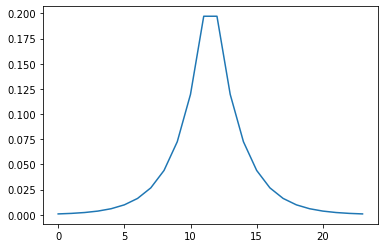

In [280]:
z=np.exp(-np.abs(np.arange(24,dtype=float)-11.5)/2+1e-3)
weights=z/np.sum(z)
print(z[11]/z[-1])
plt.plot(weights)

In [292]:
class DeConvNeuralNetwork(BaseEstimator):
    def __init__(self,learning_rate=1e-4,epochs=1000):
        self.learning_rate=learning_rate
        self.epochs=epochs
        self.model=None
    def custom_loss(self,y_actual,y_pred):
        err=y_actual-y_pred
        z=kb.exp(-kb.abs(kb.arange(24,dtype=float)-11.5)/2+1e-15)
        weights=z/kb.sum(z)
        custom_loss=kb.mean(err**2* kb.reshape(weights,(1,-1,1)))**0.5
        #custom_loss=kb.square(y_actual-y_pred)
        return custom_loss
    def fit(self,X,y=None,**fit_params):
        '''
        create a sequentil neural network
        add layers and activations
        model = Sequential(...)
        model.fit(X,y)
        '''
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(shape=5))
        model.add(tf.keras.layers.Dense(9, activation='leaky_relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Reshape((3,3,1)))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 2), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        
        model.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=(3,3), strides=(1, 1), padding='same'))
        lr_schedule=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3,decay_steps=1000,decay_rate=0.7)
        model.compile(optimizer=tf.optimizers.Adam(lr_schedule),loss=self.custom_loss,
             metrics=[ tf.keras.metrics.RootMeanSquaredError()])
        history=model.fit(X,y,epochs=self.epochs)
        self.history=history
        self.model=model
        return model,history
    def predict(self,X):
        '''
        model.predict(X)
        '''
        self.model.predict(X)
        return self.model.predict(X)
    def plot_loss(self):
        if self.history is not None:
            plt.loglog(self.history.history['loss'])
            
    def evaluate(self,X,Y):
        return self.model.evaluate(X,Y)
    def plot_model(self,to_file='large_model_plot.png', show_shapes=True, show_layer_names=False):
        plot_model(self.model, to_file='large_model_plot.png', show_shapes=True, show_layer_names=False)

In [293]:
DNN=DeConvNeuralNetwork(epochs=1000)

In [294]:
DNN.fit(X_train,Y_train)

Epoch 1/1000
7/7 [==============================] - 3s 161ms/step - loss: 0.1415 - root_mean_squared_error: 1.0386
Epoch 2/1000
7/7 [==============================] - 0s 72ms/step - loss: 0.1268 - root_mean_squared_error: 0.9867
Epoch 3/1000
7/7 [==============================] - 0s 36ms/step - loss: 0.1187 - root_mean_squared_error: 0.9698
Epoch 4/1000
7/7 [==============================] - 0s 49ms/step - loss: 0.1116 - root_mean_squared_error: 0.9545
Epoch 5/1000
7/7 [==============================] - 0s 38ms/step - loss: 0.1036 - root_mean_squared_error: 0.9336
Epoch 6/1000
7/7 [==============================] - 0s 39ms/step - loss: 0.0944 - root_mean_squared_error: 0.8982
Epoch 7/1000
7/7 [==============================] - 0s 28ms/step - loss: 0.0882 - root_mean_squared_error: 0.8496
Epoch 8/1000
7/7 [==============================] - 0s 27ms/step - loss: 0.0811 - root_mean_squared_error: 0.7919
Epoch 9/1000
7/7 [==============================] - 0s 28ms/step - loss: 0.0745 - root_

7/7 [==============================] - 0s 22ms/step - loss: 0.0317 - root_mean_squared_error: 0.2541
Epoch 73/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0308 - root_mean_squared_error: 0.2529
Epoch 74/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0283 - root_mean_squared_error: 0.2501
Epoch 75/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0278 - root_mean_squared_error: 0.2488
Epoch 76/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0288 - root_mean_squared_error: 0.2481
Epoch 77/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0283 - root_mean_squared_error: 0.2462
Epoch 78/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0272 - root_mean_squared_error: 0.2442
Epoch 79/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0273 - root_mean_squared_error: 0.2428
Epoch 80/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0277 - root_mean_s

Epoch 143/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0254 - root_mean_squared_error: 0.2043
Epoch 144/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0245 - root_mean_squared_error: 0.2026
Epoch 145/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0231 - root_mean_squared_error: 0.2008
Epoch 146/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0235 - root_mean_squared_error: 0.1994
Epoch 147/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0229 - root_mean_squared_error: 0.1993
Epoch 148/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0244 - root_mean_squared_error: 0.1996
Epoch 149/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0242 - root_mean_squared_error: 0.2006
Epoch 150/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0246 - root_mean_squared_error: 0.1990
Epoch 151/1000
7/7 [==============================] - 0s 22ms/step - los

7/7 [==============================] - 0s 21ms/step - loss: 0.0220 - root_mean_squared_error: 0.1766
Epoch 214/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0213 - root_mean_squared_error: 0.1746
Epoch 215/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0225 - root_mean_squared_error: 0.1747
Epoch 216/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0214 - root_mean_squared_error: 0.1736
Epoch 217/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0219 - root_mean_squared_error: 0.1734
Epoch 218/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0240 - root_mean_squared_error: 0.1755
Epoch 219/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0210 - root_mean_squared_error: 0.1739
Epoch 220/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0207 - root_mean_squared_error: 0.1714
Epoch 221/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0215 - roo

7/7 [==============================] - 0s 21ms/step - loss: 0.0215 - root_mean_squared_error: 0.1631
Epoch 284/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0197 - root_mean_squared_error: 0.1592
Epoch 285/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0199 - root_mean_squared_error: 0.1595
Epoch 286/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0197 - root_mean_squared_error: 0.1592
Epoch 287/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0203 - root_mean_squared_error: 0.1597
Epoch 288/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0201 - root_mean_squared_error: 0.1601
Epoch 289/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0199 - root_mean_squared_error: 0.1596
Epoch 290/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0194 - root_mean_squared_error: 0.1581
Epoch 291/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0203 - roo

7/7 [==============================] - 0s 22ms/step - loss: 0.0204 - root_mean_squared_error: 0.1531
Epoch 354/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0184 - root_mean_squared_error: 0.1503
Epoch 355/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0188 - root_mean_squared_error: 0.1501
Epoch 356/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0187 - root_mean_squared_error: 0.1495
Epoch 357/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0184 - root_mean_squared_error: 0.1491
Epoch 358/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0181 - root_mean_squared_error: 0.1491
Epoch 359/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0181 - root_mean_squared_error: 0.1488
Epoch 360/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0181 - root_mean_squared_error: 0.1494
Epoch 361/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0176 - roo

7/7 [==============================] - 0s 21ms/step - loss: 0.0183 - root_mean_squared_error: 0.1443
Epoch 424/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0188 - root_mean_squared_error: 0.1447
Epoch 425/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0181 - root_mean_squared_error: 0.1441
Epoch 426/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0179 - root_mean_squared_error: 0.1427
Epoch 427/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0174 - root_mean_squared_error: 0.1424
Epoch 428/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0175 - root_mean_squared_error: 0.1435
Epoch 429/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0173 - root_mean_squared_error: 0.1423
Epoch 430/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0172 - root_mean_squared_error: 0.1423
Epoch 431/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0178 - roo

7/7 [==============================] - 0s 21ms/step - loss: 0.0171 - root_mean_squared_error: 0.1385
Epoch 494/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0178 - root_mean_squared_error: 0.1395
Epoch 495/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0167 - root_mean_squared_error: 0.1378
Epoch 496/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0174 - root_mean_squared_error: 0.1389
Epoch 497/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0167 - root_mean_squared_error: 0.1382
Epoch 498/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0175 - root_mean_squared_error: 0.1392
Epoch 499/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0168 - root_mean_squared_error: 0.1382
Epoch 500/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0169 - root_mean_squared_error: 0.1379
Epoch 501/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0177 - roo

7/7 [==============================] - 0s 22ms/step - loss: 0.0165 - root_mean_squared_error: 0.1354
Epoch 564/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0167 - root_mean_squared_error: 0.1357
Epoch 565/1000
7/7 [==============================] - 0s 24ms/step - loss: 0.0166 - root_mean_squared_error: 0.1356
Epoch 566/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0169 - root_mean_squared_error: 0.1356
Epoch 567/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0173 - root_mean_squared_error: 0.1362
Epoch 568/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0169 - root_mean_squared_error: 0.1357
Epoch 569/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0168 - root_mean_squared_error: 0.1358
Epoch 570/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0165 - root_mean_squared_error: 0.1347
Epoch 571/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0163 - roo

7/7 [==============================] - 0s 22ms/step - loss: 0.0170 - root_mean_squared_error: 0.1342
Epoch 634/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0158 - root_mean_squared_error: 0.1319
Epoch 635/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0160 - root_mean_squared_error: 0.1323
Epoch 636/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0159 - root_mean_squared_error: 0.1322
Epoch 637/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0166 - root_mean_squared_error: 0.1330
Epoch 638/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0177 - root_mean_squared_error: 0.1338
Epoch 639/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0158 - root_mean_squared_error: 0.1313
Epoch 640/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0162 - root_mean_squared_error: 0.1327
Epoch 641/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0159 - roo

7/7 [==============================] - 0s 22ms/step - loss: 0.0154 - root_mean_squared_error: 0.1293
Epoch 704/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0155 - root_mean_squared_error: 0.1297
Epoch 705/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0154 - root_mean_squared_error: 0.1295
Epoch 706/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0160 - root_mean_squared_error: 0.1310
Epoch 707/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0156 - root_mean_squared_error: 0.1296
Epoch 708/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0158 - root_mean_squared_error: 0.1302
Epoch 709/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0154 - root_mean_squared_error: 0.1291
Epoch 710/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0158 - root_mean_squared_error: 0.1296
Epoch 711/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0152 - roo

7/7 [==============================] - 0s 22ms/step - loss: 0.0155 - root_mean_squared_error: 0.1278
Epoch 774/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0149 - root_mean_squared_error: 0.1271
Epoch 775/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0164 - root_mean_squared_error: 0.1293
Epoch 776/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0153 - root_mean_squared_error: 0.1272
Epoch 777/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0154 - root_mean_squared_error: 0.1277
Epoch 778/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0152 - root_mean_squared_error: 0.1273
Epoch 779/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0160 - root_mean_squared_error: 0.1292
Epoch 780/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0164 - root_mean_squared_error: 0.1296
Epoch 781/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0161 - roo

7/7 [==============================] - 0s 22ms/step - loss: 0.0150 - root_mean_squared_error: 0.1264
Epoch 844/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0152 - root_mean_squared_error: 0.1265
Epoch 845/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0146 - root_mean_squared_error: 0.1253
Epoch 846/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0149 - root_mean_squared_error: 0.1259
Epoch 847/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0150 - root_mean_squared_error: 0.1259
Epoch 848/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0148 - root_mean_squared_error: 0.1258
Epoch 849/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0153 - root_mean_squared_error: 0.1261
Epoch 850/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0147 - root_mean_squared_error: 0.1250
Epoch 851/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0151 - roo

7/7 [==============================] - 0s 23ms/step - loss: 0.0155 - root_mean_squared_error: 0.1249
Epoch 914/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0148 - root_mean_squared_error: 0.1243
Epoch 915/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0148 - root_mean_squared_error: 0.1244
Epoch 916/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0149 - root_mean_squared_error: 0.1248
Epoch 917/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0152 - root_mean_squared_error: 0.1249
Epoch 918/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0147 - root_mean_squared_error: 0.1243
Epoch 919/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0146 - root_mean_squared_error: 0.1239
Epoch 920/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0145 - root_mean_squared_error: 0.1237
Epoch 921/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0146 - roo

7/7 [==============================] - 0s 23ms/step - loss: 0.0147 - root_mean_squared_error: 0.1235
Epoch 984/1000
7/7 [==============================] - 0s 24ms/step - loss: 0.0151 - root_mean_squared_error: 0.1239
Epoch 985/1000
7/7 [==============================] - 0s 24ms/step - loss: 0.0143 - root_mean_squared_error: 0.1226
Epoch 986/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0148 - root_mean_squared_error: 0.1234
Epoch 987/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0145 - root_mean_squared_error: 0.1231
Epoch 988/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0147 - root_mean_squared_error: 0.1233
Epoch 989/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0152 - root_mean_squared_error: 0.1236
Epoch 990/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0146 - root_mean_squared_error: 0.1230
Epoch 991/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0147 - roo

(<keras.engine.sequential.Sequential at 0x428e38f40>,
 <keras.callbacks.History at 0x42e8bc370>)

In [295]:
DNN.evaluate(X_train,Y_train)

7/7 [==============================] - 1s 54ms/step - loss: 0.0139 - root_mean_squared_error: 0.1220


[0.013929584994912148, 0.12195649743080139]

In [296]:
DNN.evaluate(X_test,Y_test)

2/2 [==============================] - 0s 302ms/step - loss: 0.0195 - root_mean_squared_error: 0.1284


[0.019479069858789444, 0.12835049629211426]

In [297]:
Y_pred=DNN.predict(X_test)

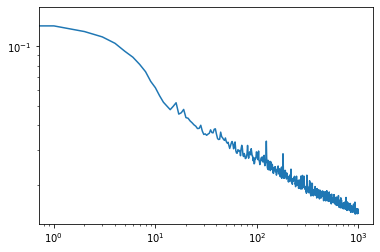

In [298]:
DNN.plot_loss()

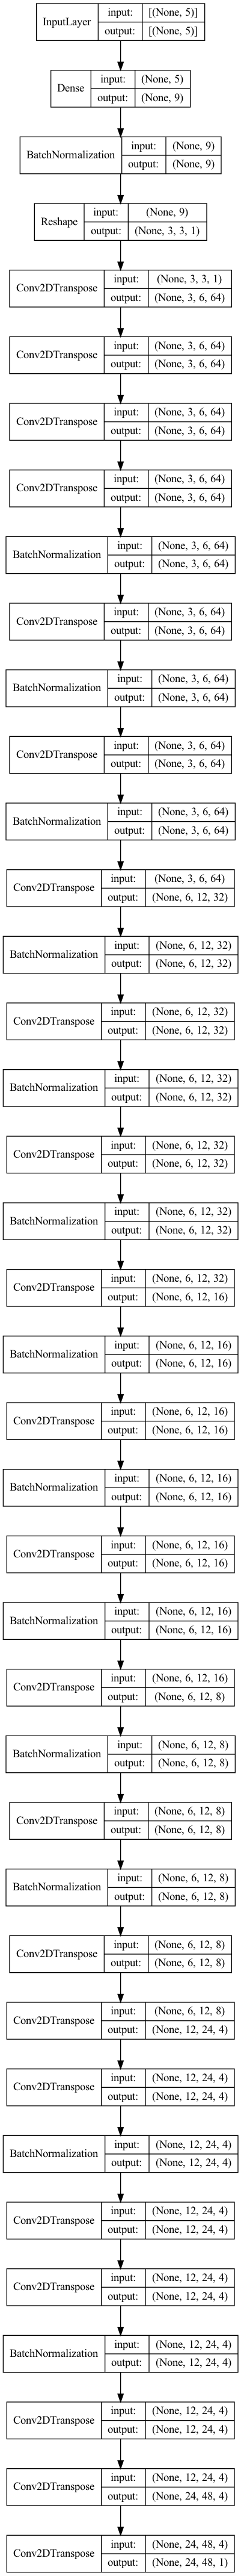

In [299]:
plot_model(DNN.model, to_file='large_model_plot.png', show_shapes=True, show_layer_names=False)

In [300]:
DNN.model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 9)                 54        
                                                                 
 batch_normalization_224 (Ba  (None, 9)                36        
 tchNormalization)                                               
                                                                 
 reshape_21 (Reshape)        (None, 3, 3, 1)           0         
                                                                 
 conv2d_transpose_244 (Conv2  (None, 3, 6, 64)         1664      
 DTranspose)                                                     
                                                                 
 conv2d_transpose_245 (Conv2  (None, 3, 6, 64)         102464    
 DTranspose)                                                     
                                                     

In [301]:
def plot(Y_pred,Y_test,i=0):
    lat = dataset['lat'].values
    lon = dataset['lon'].values
    Y_plot=np.reshape(Y_pred[i],(24,48))
    y_pred_xr = xarray.DataArray(Y_plot,coords={'lat': lat, 'lon':lon})
    sample_plot = cviz.contour.plot_lat_lon(
        cmap_name="e3sm_default",
        title="Y_pred",
        rhs_title=r"$W/m^2$",
        lhs_title="Y_E3SM",
    )
    sample_plot.show(y_pred_xr)
    Y_plot=np.reshape(Y_test[i],(24,48))
    y_obs_xr = xarray.DataArray(Y_plot,coords={'lat': lat, 'lon':lon})
    sample_plot = cviz.contour.plot_lat_lon(
        cmap_name="e3sm_default",
        title="Y_actual",
        rhs_title=r"$W/m^2$",
        lhs_title="Y_E3SM",
    )
    sample_plot.show(y_obs_xr)
    sample_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default_diff",
    title="Y_pred-Y_test",
    rhs_title=r"$W/m^2$",
    lhs_title="",
    )
    diff = y_pred_xr-y_obs_xr
    diff[0,0] = 1
    diff[0,1] = -1
    sample_plot.show((diff))

/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/

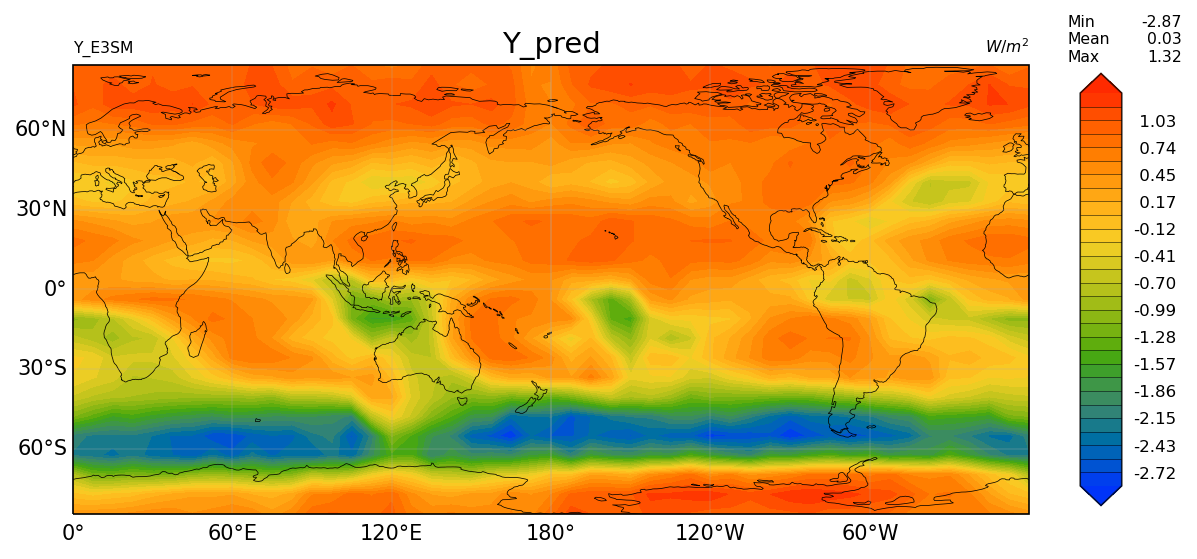

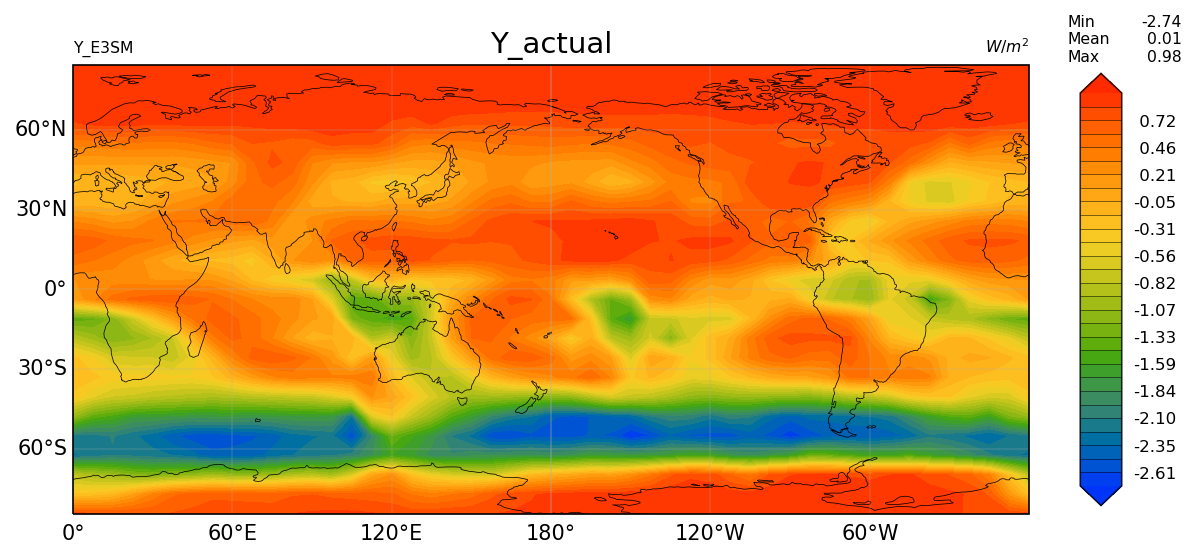

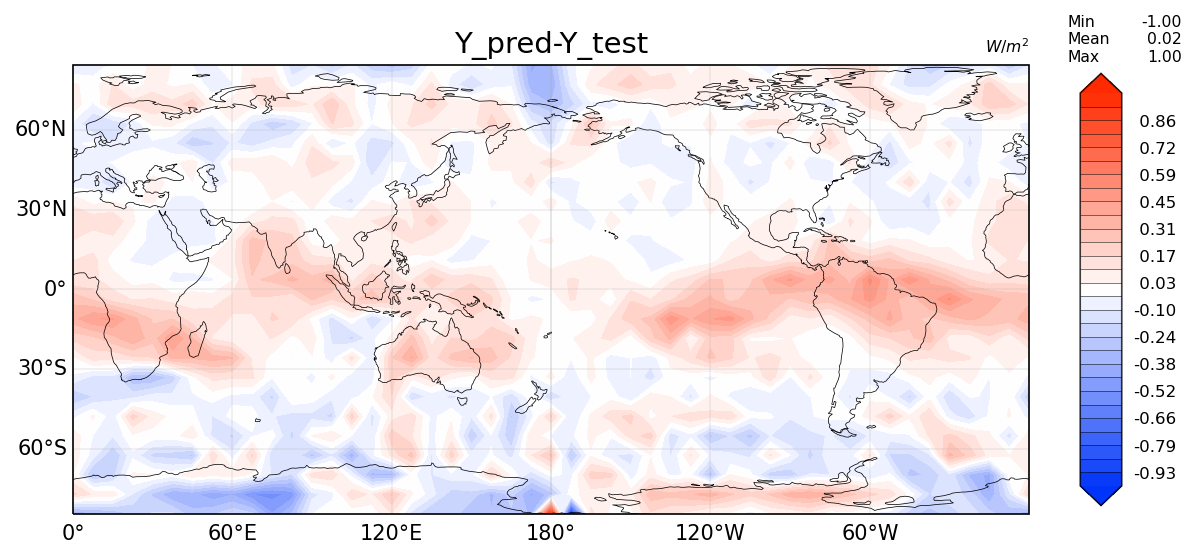

In [302]:
plot(Y_pred,Y_test,-1)

In [303]:
mse_test=np.mean(np.square(Y_pred.squeeze()-Y_test))

In [304]:
mse_train=np.mean(np.square(DNN.predict(X_train).squeeze()-Y_train))

In [305]:
mse_test,mse_train

(0.01647385, 0.014873388)

## Map from Y to X

In [991]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Conv2D(filters=1,kernel_size=(5,5), strides=(1, 1),activation='leaky_relu',input_shape=(24,48,1),padding='same'))
model2.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=512,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=512,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=512,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=512,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dense(8*500,activation='leaky_relu'))
model2.add(tf.keras.layers.Dropout(.2))
model2.add(tf.keras.layers.Dense(1000,activation='leaky_relu'))
model2.add(tf.keras.layers.Dense(300,activation='leaky_relu'))
model2.add(tf.keras.layers.Dropout(.2))
model2.add(tf.keras.layers.Dense(100,activation='leaky_relu'))
model2.add(tf.keras.layers.Dense(5))
model2.add(tf.keras.layers.Dense(5, activation='tanh'))



In [992]:
model2.summary()

Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_517 (Conv2D)         (None, 24, 48, 1)         26        
                                                                 
 conv2d_518 (Conv2D)         (None, 12, 24, 64)        1664      
                                                                 
 batch_normalization_709 (Ba  (None, 12, 24, 64)       256       
 tchNormalization)                                               
                                                                 
 conv2d_519 (Conv2D)         (None, 12, 24, 64)        102464    
                                                                 
 batch_normalization_710 (Ba  (None, 12, 24, 64)       256       
 tchNormalization)                                               
                                                                 
 conv2d_520 (Conv2D)         (None, 12, 24, 64)      

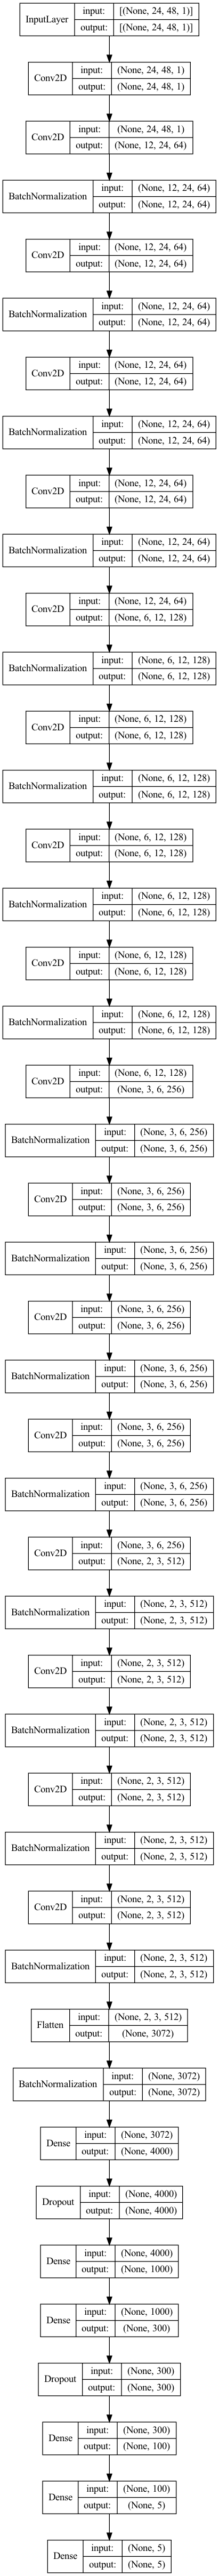

In [993]:
plot_model(model2, to_file='large_model_plot.png', show_shapes=True, show_layer_names=False)

In [994]:
def custom_loss2(y_pred,y_actual):
    return kb.square(y_pred-y_actual)

In [900]:
lr_schedule=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4,decay_steps=1000,decay_rate=0.95)


In [901]:
model2.compile(optimizer=tf.optimizers.Adam(lr_schedule),loss=custom_loss2,
             metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [919]:
history=model2.fit(Y_train,X_train,epochs=1000)

Epoch 1/1000
7/7 [==============================] - 1s 122ms/step - loss: 0.5415 - root_mean_squared_error: 0.5489
Epoch 2/1000
7/7 [==============================] - 0s 65ms/step - loss: 0.5371 - root_mean_squared_error: 0.5457
Epoch 3/1000
7/7 [==============================] - 1s 76ms/step - loss: 0.5370 - root_mean_squared_error: 0.5464
Epoch 4/1000
7/7 [==============================] - 0s 67ms/step - loss: 0.5394 - root_mean_squared_error: 0.5493
Epoch 5/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.5322 - root_mean_squared_error: 0.5435
Epoch 6/1000
7/7 [==============================] - 1s 74ms/step - loss: 0.5602 - root_mean_squared_error: 0.5693
Epoch 7/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.5384 - root_mean_squared_error: 0.5506
Epoch 8/1000
7/7 [==============================] - 0s 69ms/step - loss: 0.5343 - root_mean_squared_error: 0.5474
Epoch 9/1000
7/7 [==============================] - 0s 65ms/step - loss: 0.5406 - root_

7/7 [==============================] - 0s 72ms/step - loss: 0.4765 - root_mean_squared_error: 0.5414
Epoch 73/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.4735 - root_mean_squared_error: 0.5394
Epoch 74/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.4713 - root_mean_squared_error: 0.5381
Epoch 75/1000
7/7 [==============================] - 0s 63ms/step - loss: 0.4710 - root_mean_squared_error: 0.5386
Epoch 76/1000
7/7 [==============================] - 0s 69ms/step - loss: 0.4683 - root_mean_squared_error: 0.5368
Epoch 77/1000
7/7 [==============================] - 0s 66ms/step - loss: 0.4679 - root_mean_squared_error: 0.5372
Epoch 78/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.4680 - root_mean_squared_error: 0.5381
Epoch 79/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.4661 - root_mean_squared_error: 0.5370
Epoch 80/1000
7/7 [==============================] - 0s 68ms/step - loss: 0.4649 - root_mean_s

Epoch 143/1000
7/7 [==============================] - 0s 67ms/step - loss: 0.4256 - root_mean_squared_error: 0.5364
Epoch 144/1000
7/7 [==============================] - 0s 66ms/step - loss: 0.4253 - root_mean_squared_error: 0.5367
Epoch 145/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.4253 - root_mean_squared_error: 0.5374
Epoch 146/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.4267 - root_mean_squared_error: 0.5393
Epoch 147/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.4233 - root_mean_squared_error: 0.5368
Epoch 148/1000
7/7 [==============================] - 0s 63ms/step - loss: 0.4239 - root_mean_squared_error: 0.5379
Epoch 149/1000
7/7 [==============================] - 0s 70ms/step - loss: 0.4235 - root_mean_squared_error: 0.5383
Epoch 150/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.4216 - root_mean_squared_error: 0.5371
Epoch 151/1000
7/7 [==============================] - 0s 64ms/step - los

7/7 [==============================] - 0s 66ms/step - loss: 0.3842 - root_mean_squared_error: 0.5335
Epoch 214/1000
7/7 [==============================] - 0s 66ms/step - loss: 0.3864 - root_mean_squared_error: 0.5360
Epoch 215/1000
7/7 [==============================] - 0s 66ms/step - loss: 0.3868 - root_mean_squared_error: 0.5368
Epoch 216/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.3948 - root_mean_squared_error: 0.5446
Epoch 217/1000
7/7 [==============================] - 0s 63ms/step - loss: 0.3863 - root_mean_squared_error: 0.5369
Epoch 218/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.3888 - root_mean_squared_error: 0.5392
Epoch 219/1000
7/7 [==============================] - 0s 70ms/step - loss: 0.3876 - root_mean_squared_error: 0.5383
Epoch 220/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.3881 - root_mean_squared_error: 0.5390
Epoch 221/1000
7/7 [==============================] - 0s 63ms/step - loss: 0.3880 - roo

7/7 [==============================] - 0s 63ms/step - loss: 0.6575 - root_mean_squared_error: 0.5887
Epoch 284/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.6624 - root_mean_squared_error: 0.5917
Epoch 285/1000
7/7 [==============================] - 0s 66ms/step - loss: 0.6689 - root_mean_squared_error: 0.5890
Epoch 286/1000
7/7 [==============================] - 0s 70ms/step - loss: 0.6895 - root_mean_squared_error: 0.5956
Epoch 287/1000
7/7 [==============================] - 0s 63ms/step - loss: 0.7211 - root_mean_squared_error: 0.6095
Epoch 288/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.7191 - root_mean_squared_error: 0.5978
Epoch 289/1000
7/7 [==============================] - 0s 66ms/step - loss: 0.7141 - root_mean_squared_error: 0.5883
Epoch 290/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.7096 - root_mean_squared_error: 0.5826
Epoch 291/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.7142 - roo

7/7 [==============================] - 0s 72ms/step - loss: 0.6484 - root_mean_squared_error: 0.5549
Epoch 354/1000
7/7 [==============================] - 0s 65ms/step - loss: 0.6427 - root_mean_squared_error: 0.5514
Epoch 355/1000
7/7 [==============================] - 0s 65ms/step - loss: 0.6413 - root_mean_squared_error: 0.5518
Epoch 356/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.6441 - root_mean_squared_error: 0.5560
Epoch 357/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.6340 - root_mean_squared_error: 0.5485
Epoch 358/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.6512 - root_mean_squared_error: 0.5655
Epoch 359/1000
7/7 [==============================] - 0s 69ms/step - loss: 0.6275 - root_mean_squared_error: 0.5458
Epoch 360/1000
7/7 [==============================] - 0s 65ms/step - loss: 0.6284 - root_mean_squared_error: 0.5483
Epoch 361/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.6442 - roo

7/7 [==============================] - 0s 64ms/step - loss: 0.8524 - root_mean_squared_error: 0.5718
Epoch 424/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.8511 - root_mean_squared_error: 0.5721
Epoch 425/1000
7/7 [==============================] - 0s 66ms/step - loss: 0.8440 - root_mean_squared_error: 0.5672
Epoch 426/1000
7/7 [==============================] - 0s 66ms/step - loss: 0.8391 - root_mean_squared_error: 0.5643
Epoch 427/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.8528 - root_mean_squared_error: 0.5777
Epoch 428/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.8331 - root_mean_squared_error: 0.5618
Epoch 429/1000
7/7 [==============================] - 0s 66ms/step - loss: 0.8331 - root_mean_squared_error: 0.5631
Epoch 430/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.8318 - root_mean_squared_error: 0.5634
Epoch 431/1000
7/7 [==============================] - 0s 66ms/step - loss: 0.8301 - roo

7/7 [==============================] - 0s 68ms/step - loss: 0.7284 - root_mean_squared_error: 0.5500
Epoch 494/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.7296 - root_mean_squared_error: 0.5522
Epoch 495/1000
7/7 [==============================] - 0s 66ms/step - loss: 0.7312 - root_mean_squared_error: 0.5549
Epoch 496/1000
7/7 [==============================] - 0s 63ms/step - loss: 0.7298 - root_mean_squared_error: 0.5547
Epoch 497/1000
7/7 [==============================] - 0s 68ms/step - loss: 0.7263 - root_mean_squared_error: 0.5527
Epoch 498/1000
7/7 [==============================] - 0s 63ms/step - loss: 0.7235 - root_mean_squared_error: 0.5513
Epoch 499/1000
7/7 [==============================] - 0s 63ms/step - loss: 0.7229 - root_mean_squared_error: 0.5519
Epoch 500/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.7332 - root_mean_squared_error: 0.5622
Epoch 501/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.7257 - roo

7/7 [==============================] - 0s 68ms/step - loss: 0.9195 - root_mean_squared_error: 0.5692
Epoch 564/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.9170 - root_mean_squared_error: 0.5681
Epoch 565/1000
7/7 [==============================] - 0s 63ms/step - loss: 0.9166 - root_mean_squared_error: 0.5687
Epoch 566/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.9131 - root_mean_squared_error: 0.5667
Epoch 567/1000
7/7 [==============================] - 0s 66ms/step - loss: 0.9110 - root_mean_squared_error: 0.5657
Epoch 568/1000
7/7 [==============================] - 0s 66ms/step - loss: 0.9095 - root_mean_squared_error: 0.5653
Epoch 569/1000
7/7 [==============================] - 0s 63ms/step - loss: 0.9073 - root_mean_squared_error: 0.5642
Epoch 570/1000
7/7 [==============================] - 0s 69ms/step - loss: 0.9048 - root_mean_squared_error: 0.5629
Epoch 571/1000
7/7 [==============================] - 0s 65ms/step - loss: 0.9053 - roo

7/7 [==============================] - 0s 68ms/step - loss: 0.8225 - root_mean_squared_error: 0.5499
Epoch 634/1000
7/7 [==============================] - 0s 67ms/step - loss: 0.8217 - root_mean_squared_error: 0.5501
Epoch 635/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.8195 - root_mean_squared_error: 0.5490
Epoch 636/1000
7/7 [==============================] - 0s 70ms/step - loss: 0.8187 - root_mean_squared_error: 0.5492
Epoch 637/1000
7/7 [==============================] - 0s 66ms/step - loss: 0.8180 - root_mean_squared_error: 0.5496
Epoch 638/1000
7/7 [==============================] - 0s 68ms/step - loss: 0.8156 - root_mean_squared_error: 0.5483
Epoch 639/1000
7/7 [==============================] - 0s 67ms/step - loss: 0.8142 - root_mean_squared_error: 0.5480
Epoch 640/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.8153 - root_mean_squared_error: 0.5499
Epoch 641/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.8131 - roo

7/7 [==============================] - 0s 68ms/step - loss: 0.7493 - root_mean_squared_error: 0.5461
Epoch 704/1000
7/7 [==============================] - 0s 66ms/step - loss: 0.7487 - root_mean_squared_error: 0.5464
Epoch 705/1000
7/7 [==============================] - 0s 71ms/step - loss: 0.7492 - root_mean_squared_error: 0.5477
Epoch 706/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.7478 - root_mean_squared_error: 0.5473
Epoch 707/1000
7/7 [==============================] - 0s 65ms/step - loss: 0.7457 - root_mean_squared_error: 0.5462
Epoch 708/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.7458 - root_mean_squared_error: 0.5471
Epoch 709/1000
7/7 [==============================] - 0s 68ms/step - loss: 0.7437 - root_mean_squared_error: 0.5461
Epoch 710/1000
7/7 [==============================] - 0s 65ms/step - loss: 0.7409 - root_mean_squared_error: 0.5444
Epoch 711/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.7432 - roo

7/7 [==============================] - 0s 65ms/step - loss: 0.6875 - root_mean_squared_error: 0.5465
Epoch 774/1000
7/7 [==============================] - 0s 71ms/step - loss: 0.6879 - root_mean_squared_error: 0.5477
Epoch 775/1000
7/7 [==============================] - 0s 68ms/step - loss: 0.6851 - root_mean_squared_error: 0.5459
Epoch 776/1000
7/7 [==============================] - 0s 65ms/step - loss: 0.6844 - root_mean_squared_error: 0.5461
Epoch 777/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.6826 - root_mean_squared_error: 0.5451
Epoch 778/1000
7/7 [==============================] - 0s 69ms/step - loss: 0.6822 - root_mean_squared_error: 0.5456
Epoch 779/1000
7/7 [==============================] - 0s 67ms/step - loss: 0.6815 - root_mean_squared_error: 0.5457
Epoch 780/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.6813 - root_mean_squared_error: 0.5462
Epoch 781/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.6803 - roo

7/7 [==============================] - 0s 64ms/step - loss: 0.6300 - root_mean_squared_error: 0.5452
Epoch 844/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.6300 - root_mean_squared_error: 0.5459
Epoch 845/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.6281 - root_mean_squared_error: 0.5449
Epoch 846/1000
7/7 [==============================] - 0s 66ms/step - loss: 0.6276 - root_mean_squared_error: 0.5451
Epoch 847/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.6261 - root_mean_squared_error: 0.5444
Epoch 848/1000
7/7 [==============================] - 0s 69ms/step - loss: 0.6264 - root_mean_squared_error: 0.5453
Epoch 849/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.6263 - root_mean_squared_error: 0.5460
Epoch 850/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.6243 - root_mean_squared_error: 0.5449
Epoch 851/1000
7/7 [==============================] - 0s 67ms/step - loss: 0.6257 - roo

7/7 [==============================] - 0s 67ms/step - loss: 0.5831 - root_mean_squared_error: 0.5481
Epoch 914/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.5805 - root_mean_squared_error: 0.5463
Epoch 915/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.5809 - root_mean_squared_error: 0.5473
Epoch 916/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.5788 - root_mean_squared_error: 0.5459
Epoch 917/1000
7/7 [==============================] - 0s 66ms/step - loss: 0.5777 - root_mean_squared_error: 0.5456
Epoch 918/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.5782 - root_mean_squared_error: 0.5466
Epoch 919/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.5760 - root_mean_squared_error: 0.5452
Epoch 920/1000
7/7 [==============================] - 0s 66ms/step - loss: 0.5755 - root_mean_squared_error: 0.5454
Epoch 921/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.5739 - roo

7/7 [==============================] - 0s 65ms/step - loss: 0.5349 - root_mean_squared_error: 0.5444
Epoch 984/1000
7/7 [==============================] - 0s 65ms/step - loss: 0.5350 - root_mean_squared_error: 0.5451
Epoch 985/1000
7/7 [==============================] - 0s 65ms/step - loss: 0.5342 - root_mean_squared_error: 0.5449
Epoch 986/1000
7/7 [==============================] - 0s 65ms/step - loss: 0.5349 - root_mean_squared_error: 0.5461
Epoch 987/1000
7/7 [==============================] - 0s 69ms/step - loss: 0.5332 - root_mean_squared_error: 0.5451
Epoch 988/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.5325 - root_mean_squared_error: 0.5449
Epoch 989/1000
7/7 [==============================] - 0s 65ms/step - loss: 0.5330 - root_mean_squared_error: 0.5460
Epoch 990/1000
7/7 [==============================] - 0s 64ms/step - loss: 0.5321 - root_mean_squared_error: 0.5456
Epoch 991/1000
7/7 [==============================] - 0s 68ms/step - loss: 0.5322 - roo

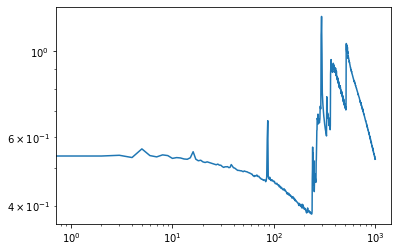

In [920]:
plt.loglog(history.history['loss'])

In [921]:
x_pred=model2.predict(Y_test)

In [922]:
x_pred

array([[-0.06253848, -0.15074718, -0.10264677, -0.47895896,  0.19621755],
       [-0.06253848, -0.15074718, -0.10264677, -0.47895896,  0.19621755],
       [-0.06253848, -0.15074718, -0.10264677, -0.47895896,  0.19621755],
       [-0.06253848, -0.15074718, -0.10264677, -0.47895896,  0.19621755],
       [-0.06253848, -0.15074718, -0.10264677, -0.47895896,  0.19621755],
       [-0.06253848, -0.15074718, -0.10264677, -0.47895896,  0.19621755],
       [-0.06253848, -0.15074718, -0.10264677, -0.47895896,  0.19621755],
       [-0.06253848, -0.15074718, -0.10264677, -0.47895896,  0.19621755],
       [-0.06253848, -0.15074718, -0.10264677, -0.47895896,  0.19621755],
       [-0.06253848, -0.15074718, -0.10264677, -0.47895896,  0.19621755],
       [-0.06253848, -0.15074718, -0.10264677, -0.47895896,  0.19621755],
       [-0.06253848, -0.15074718, -0.10264677, -0.47895896,  0.19621755],
       [-0.06253848, -0.15074718, -0.10264677, -0.47895896,  0.19621755],
       [-0.06253848, -0.15074718, -0.1

In [923]:
x_pred.min(),x_pred.max()

(-0.47895896, 0.19621755)

In [924]:
model2.evaluate(Y_train,X_train)

7/7 [==============================] - 0s 52ms/step - loss: 0.6283 - root_mean_squared_error: 0.6325


[0.6282778978347778, 0.6325041055679321]

In [925]:
model2.evaluate(Y_test,X_test)

2/2 [==============================] - 0s 63ms/step - loss: 0.6094 - root_mean_squared_error: 0.6174


[0.6093711256980896, 0.6173772811889648]

In [926]:
Y_obs_re=Y_obs.reshape(1,24,48)

In [927]:
x_obs_a=model2.predict(Y_obs_re)

In [950]:
for i in range(len(model2.weights)):
    print(np.min(np.array(model2.weights[i])))

-0.269055
0.040507518
-0.11921177
-0.042469524
0.92887455
-0.040492486
-0.031641588
0.00042992603
-0.11145619
-0.06879455
0.9248598
-0.048083078
1.0612874
7.135839
-0.109285645
-0.06420427
0.92384106
-0.056556653
0.7321456
4.4017563
-0.10123177
-0.033827145
0.9373601
-0.02895135
1.3672296
12.394247
-0.089663886
-0.048515774
0.9319194
-0.0626832
0.97740024
7.9200363
-0.08035866
-0.043441996
0.92267895
-0.048752796
0.12622161
12.94239
-0.09157236
-0.06341926
0.9200172
-0.030333634
1.0950906
22.847034
-0.084064014
-0.051190484
0.8982601
-0.04180891
1.1423987
15.6051855
-0.06289448
-0.0657013
0.9411503
-0.044417456
0.2922048
1.9085841
-0.0639343
-0.055043034
0.93669266
-0.046683893
-1.1046016
2.4503098
-0.059313223
-0.05459365
0.9127385
-0.05480049
-1.304138
0.59574777
-0.0592951
-0.06976595
0.9314721
-0.0783116
0.08643979
5.768591
-0.05284306
-0.052049838
0.9090715
-0.07804561
-1.237746
0.290137
-0.046372034
-0.05378322
0.9267329
-0.06313343
-0.47221363
0.44803867
-0.04669106
-0.072541684

In [928]:
x_obs_a

array([[-0.0625385 , -0.15074721, -0.10264674, -0.47895896,  0.19621754]],
      dtype=float32)

In [929]:
Y_obs_pred=DNN.predict(x_obs_a)

In [945]:
np.min(np.array(model2.weights[-1]))

-0.1014069

[[ 0.8902467   1.1519022   1.0771085  ...  0.5637691   0.6084936
   0.53662384]
 [ 0.63325185  0.8985657   0.96379185 ...  0.39795405  0.6186644
   0.5046496 ]
 [-0.08753078 -0.07377034  0.2755038  ... -0.4887667  -0.4024873
  -0.2968754 ]
 ...
 [ 0.58425015  0.7432871   0.97731733 ...  0.9513528   0.8658974
   0.64079034]
 [ 0.60622644  0.9298851   1.1196028  ...  0.847274    0.90013635
   0.5434663 ]
 [ 0.6769517   0.9551307   1.0384917  ...  0.8522003   0.8116337
   0.52006304]]


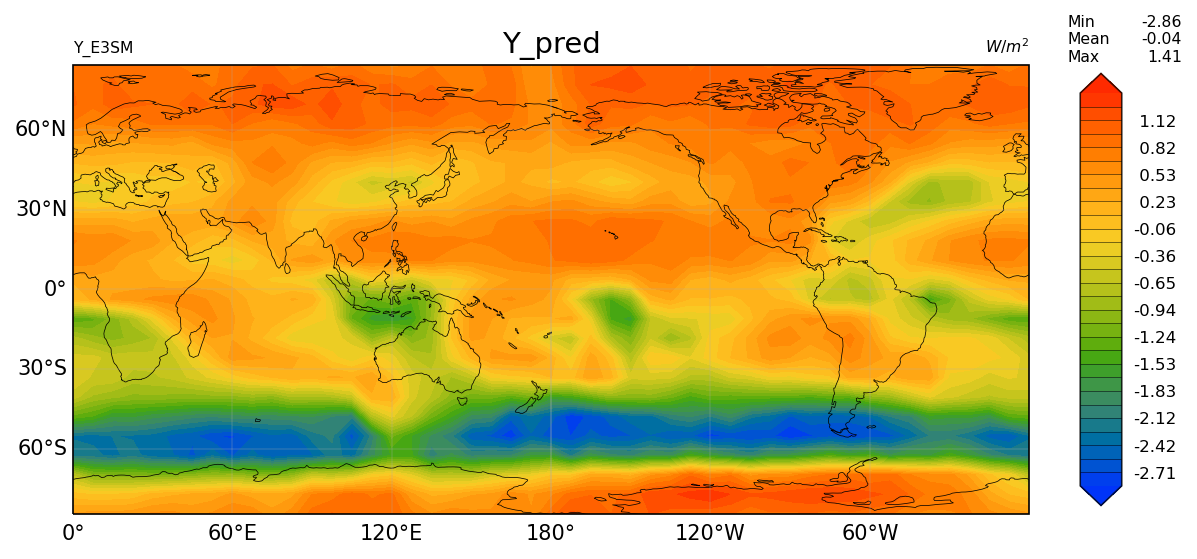

In [930]:
lat = dataset['lat'].values
lon = dataset['lon'].values
Y_plot=np.reshape(Y_obs_pred,(24,48))
print(Y_plot)
y_pred_xr = xarray.DataArray(Y_plot,coords={'lat': lat, 'lon':lon})
sample_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default",
    title="Y_pred",
    rhs_title=r"$W/m^2$",
    lhs_title="Y_E3SM",
)
sample_plot.show(y_pred_xr)

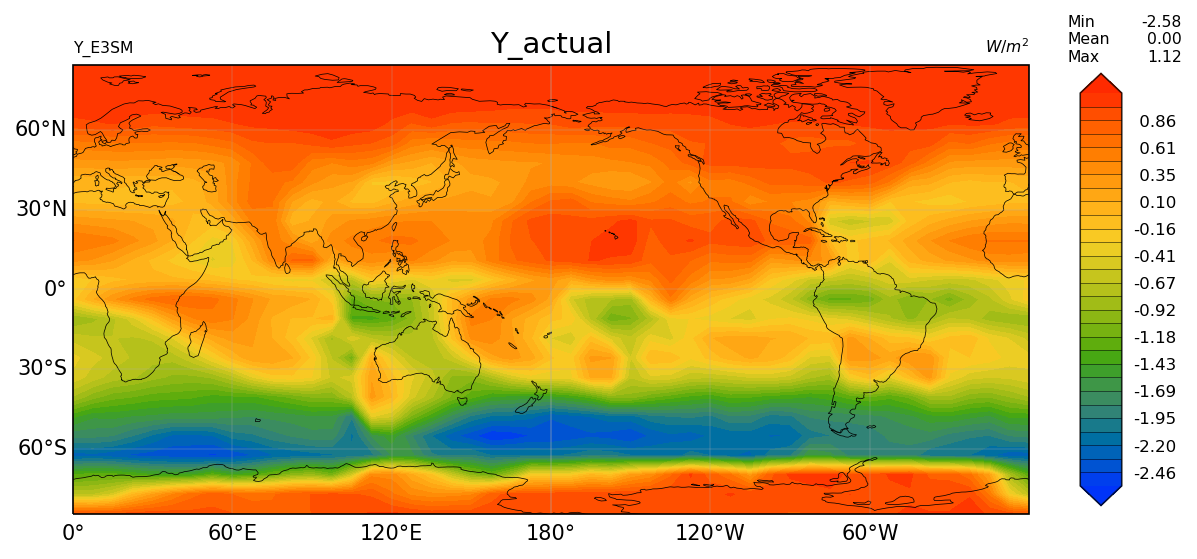

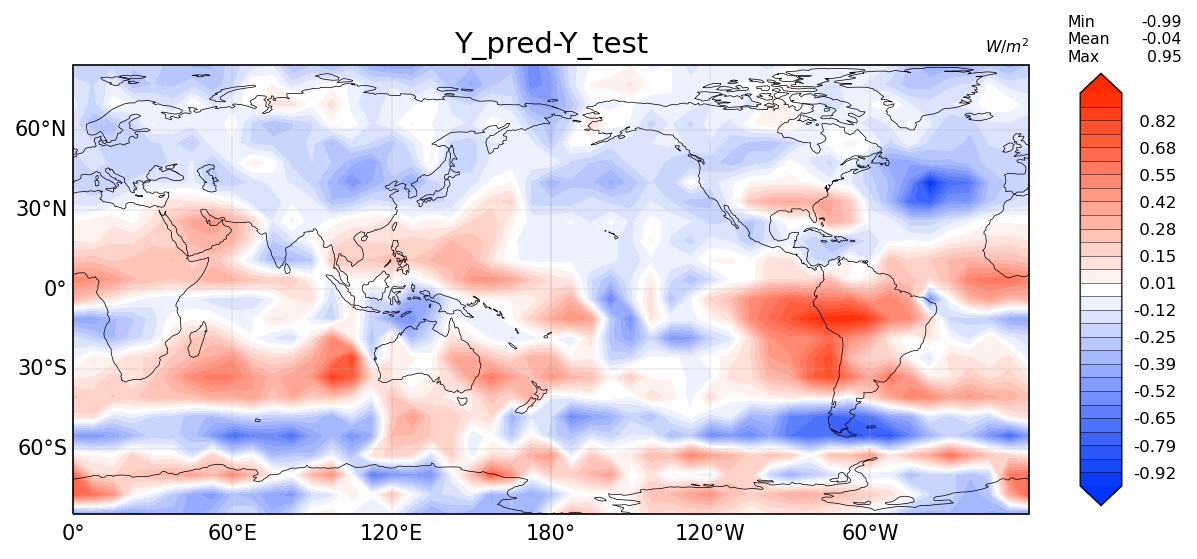

In [931]:
Y_plot=np.reshape(Y_obs,(24,48))
y_obs_xr = xarray.DataArray(Y_plot,coords={'lat': lat, 'lon':lon})
sample_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default",
    title="Y_actual",
    rhs_title=r"$W/m^2$",
    lhs_title="Y_E3SM",
)
sample_plot.show(y_obs_xr)
sample_plot = cviz.contour.plot_lat_lon(
cmap_name="e3sm_default_diff",
title="Y_pred-Y_test",
rhs_title=r"$W/m^2$",
lhs_title="",
)
sample_plot.show((y_pred_xr-y_obs_xr))

In [932]:
np.mean(np.square(Y_obs-Y_obs_pred.squeeze()))

0.0773765

In [933]:
np.min(np.mean(np.square(Y_obs-Y), axis=(1,2)))

0.059853606

In [934]:
np.mean(np.square(Y_obs-Y[196].squeeze()))

0.059853606

In [935]:
Y_obs.shape

(24, 48)

In [986]:
class ConvDeconvModel(BaseEstimator):
    def __init__(self,learning_rate=1e-4,epochs=1000):
        self.learning_rate=learning_rate
        self.epochs=epochs
        self.model=None
    def custom_loss(self,y_actual,y_pred):
        err=y_actual-y_pred
        z=kb.exp(-kb.abs(kb.arange(24,dtype=float)-11.5)/2+1e-15)
        weights=z/kb.sum(z)
        custom_loss=kb.mean(err**2* kb.reshape(weights,(1,-1,1)))**0.5
        #custom_loss=kb.square(y_actual-y_pred)
        return custom_loss
    def fit(self,X,y=None,**fit_params):
        '''
        create a sequentil neural network
        add layers and activations
        model = Sequential(...)
        model.fit(X,y)
        '''
        surr = tf.keras.Sequential()
        surr.add(tf.keras.Input(shape=5))
        surr.add(tf.keras.layers.Dense(9, activation='leaky_relu'))
        surr.add(tf.keras.layers.Dense(9, activation='leaky_relu'))
        surr.add(tf.keras.layers.Dense(36, activation='leaky_relu'))

        
        enc = tf.keras.Sequential()
        enc.add(tf.keras.layers.Conv2D(filters=1,kernel_size=(5,5), strides=(1, 1),activation='leaky_relu',input_shape=(24,48,1),padding='same'))
        enc.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        enc.add(tf.keras.layers.BatchNormalization())
        enc.add(tf.keras.layers.Conv2D(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        enc.add(tf.keras.layers.BatchNormalization())
        enc.add(tf.keras.layers.Conv2D(filters=8,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        enc.add(tf.keras.layers.BatchNormalization())   
        enc.add(tf.keras.layers.Conv2D(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        enc.add(tf.keras.layers.BatchNormalization())
        enc.add(tf.keras.layers.Conv2D(filters=4,kernel_size=(5,5), strides=(1, 2), activation='leaky_relu', padding='same'))
        enc.add(tf.keras.layers.BatchNormalization())   
        enc.add(tf.keras.layers.Conv2D(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        enc.add(tf.keras.layers.BatchNormalization())
        enc.add(tf.keras.layers.Conv2D(filters=1,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same', name='out'))
    
    
        dec = tf.keras.Sequential()
        enc.add(tf.keras.layers.Conv2D(filters=1,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        enc.add(tf.keras.layers.BatchNormalization())
        enc.add(tf.keras.layers.Conv2D(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
        enc.add(tf.keras.layers.BatchNormalization())
        enc.add(tf.keras.layers.Conv2D(filters=4,kernel_size=(5,5), strides=(1, 2), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
        enc.add(tf.keras.layers.BatchNormalization())
        enc.add(tf.keras.layers.Conv2D(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
        enc.add(tf.keras.layers.BatchNormalization())
        enc.add(tf.keras.layers.Conv2D(filters=8,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
        enc.add(tf.keras.layers.BatchNormalization())
        enc.add(tf.keras.layers.Conv2D(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
        enc.add(tf.keras.layers.BatchNormalization())
        enc.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
        enc.add(tf.keras.layers.BatchNormalization())
        enc.add(tf.keras.layers.Conv2D(filters=1,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
    

        #lr_schedule=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3,decay_steps=1000,decay_rate=0.7)
        #dec.compile(optimizer=tf.optimizers.Adam(lr_schedule),loss=self.custom_loss,
             #metrics=[ tf.keras.metrics.RootMeanSquaredError()])
        
       # enc.fit(y,y)
#         enc.get_layer
        
        #history=model.fit(X,y,epochs=self.epochs)
        ##self.history=history
        #self.model=model
        return enc,history
    
    def predict(self,X):
        '''
        model.predict(X)
        '''
        self.model.predict(X)
        return self.model.predict(X)
    def plot_loss(self):
        if self.history is not None:
            plt.loglog(self.history.history['loss'])
            
    def evaluate(self,X,Y):
        return self.model.evaluate(X,Y)
    def plot_model(self,to_file='large_model_plot.png', show_shapes=True, show_layer_names=False):
        plot_model(self.model, to_file='large_model_plot.png', show_shapes=True, show_layer_names=False)

In [987]:
CDN=ConvDeconvModel()

In [988]:
CDN.fit(X_train,Y_train)

(<keras.engine.sequential.Sequential at 0x488d7d0a0>,
 <keras.callbacks.History at 0x58dcdb640>)